In [2]:
import os
os.environ['TF_C_API_GRAPH_CONSTRUCTION']='0'
import tensorflow as tf
import edward as ed
import matplotlib.pyplot as plt
import numpy as np
from edward.models import Normal
import seaborn as sns
plt.style.use('ggplot')
from edward.models import Bernoulli, MultivariateNormalTriL, Normal
from edward.util import rbf
from observations import crabs

In [3]:
data, metadata = crabs("~/data")
X_train = data[:100, 3:]
X_test = data[100:200, 3:]
y_train = data[:100, 1]
y_test = data[100:200, 1]

N = X_train.shape[0]  
D = X_train.shape[1]  

print("Number of data points: {}".format(N))
print("Number of features: {}".format(D))

Number of data points: 100
Number of features: 5


In [4]:
X = tf.placeholder(tf.float32, [N, D])
f = MultivariateNormalTriL(loc=tf.zeros(N), scale_tril=tf.cholesky(rbf(X)))
#w = Normal(loc=tf.zeros(D), scale=tf.ones(D))
b = Normal(loc=tf.zeros(1), scale=tf.ones(1))
y = Normal(loc=f + b, scale=tf.ones(N))

In [5]:
qf = Normal(loc=tf.get_variable("qf/loc", [N]), scale=tf.nn.softplus(tf.get_variable("qf/scale", [N])))
qb = Normal(loc=tf.get_variable("qb/loc", [1]), scale=tf.nn.softplus(tf.get_variable("qb/scale", [1])))

In [6]:
inference = ed.KLqp({f: qf, b: qb}, data={X: X_train, y: y_train})
inference.run(n_iter=5000)

5000/5000 [100%] ██████████████████████████████ Elapsed: 8s | Loss: 144.821


In [40]:
y_post = Normal(loc = qf + qb, scale = tf.ones(N))

sess = ed.get_session()
np.mean([sess.run(y_post, feed_dict={X: X_test}) for _ in range(1000)]) 

0.50871706

In [41]:
samplers = np.array([sess.run(y_post, feed_dict={X: X_test}) for _ in range(1000)])
predict = np.arange(N)
predict = predict.astype(float)
for i in range(N):
    predict[i] = np.mean(samplers[:,i])

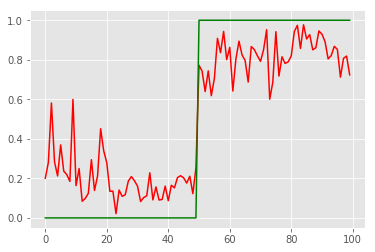

In [42]:
plt.plot(predict, color = 'red')
plt.plot(y_test, color = 'green')